In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Data Import and Clean ###

In [2]:
# Heart Attack Data
ha_costs_df = pd.read_csv('../data/mmd_heart_attack_data.csv')
ha_costs_df = ha_costs_df.query('state == "TENNESSEE"')
tn_ha_costs = ha_costs_df[['county','urban','analysis_value']]

# Cancer Data
cancer_costs_df = pd.read_csv('../data/mmd_cancer_data.csv')
cancer_costs_df = cancer_costs_df.query('state == "TENNESSEE"')
tn_cancer_costs = cancer_costs_df[['county','urban','analysis_value']]

# Income data
income_df = pd.read_csv('../data/irs_county_2016.csv')
income_df = income_df.query('STATE == "TN"')
column_list = ['STATE', 'COUNTYNAME', 'agi_stub', 'N1', 'mars1', 'MARS2', 'MARS4', 'N2', 'NUMDEP', 'ELDERLY', 'A00100', 'N02650', 'A02650', 'N02300', 'A02300']
income_df = income_df[column_list]
new_column_list = ['state', 'county', 'income_bucket', 'return_count', 'single_returns', 'joint_returns', 'head_of_house_returns', 'exemptions', 'dependents', 'elderly', 'agi', 'returns_with_total_inc','total_inc_amt', 'returns_with_unemployment', 'unemployment_comp']
column_name_dict = dict(zip(column_list,new_column_list))
income_df = income_df.rename(columns = column_name_dict)
value_key = income_df.income_bucket.unique().tolist()
value_list = ['Total', 'Under $1', 'Between 1 and $10,000', 'Between 10,000 and $25,000','Between 25,000 and $50,000', 'Between 50,000 and $75,000', 'Between 75,000 and $100,000', 'Between 100,000 and $200,000', '$200,000 or more'
        ]
income_dict = dict(zip(value_key,value_list[1:]))
income_df.income_bucket = income_df.income_bucket.replace(income_dict)
income_county_agg = income_df.groupby(['county']).sum()
income_county_agg = income_county_agg.reset_index()
income_county_agg['avg_income'] = round(income_county_agg.total_inc_amt * 1000 / income_county_agg.return_count)

tn_ha_cost2 = pd.merge(income_county_agg[['county','avg_income']], tn_ha_costs, on="county", how = 'left')
tn_ha_cost2['cost_income_ratio'] = tn_ha_cost2.analysis_value / tn_ha_cost2.avg_income
tn_ha_cost2['classifer'] = 0
tn_ha_cost2.loc[tn_ha_cost2.cost_income_ratio > tn_ha_cost2.cost_income_ratio.mean(),'classifer'] = 1
tn_ha_cost2 = pd.get_dummies(tn_ha_cost2, columns = ['urban'], drop_first = True)

tn_cancer_cost2 = pd.merge(income_county_agg[['county','avg_income']], tn_cancer_costs, on="county", how = 'left')
tn_cancer_cost2['cost_income_ratio'] = tn_cancer_cost2.analysis_value / tn_cancer_cost2.avg_income
tn_cancer_cost2['classifer'] = 0
tn_cancer_cost2.loc[tn_cancer_cost2.cost_income_ratio > tn_cancer_cost2.cost_income_ratio.mean(),'classifer'] = 1
tn_cancer_cost2 = pd.get_dummies(tn_cancer_cost2, columns = ['urban'], drop_first = True)

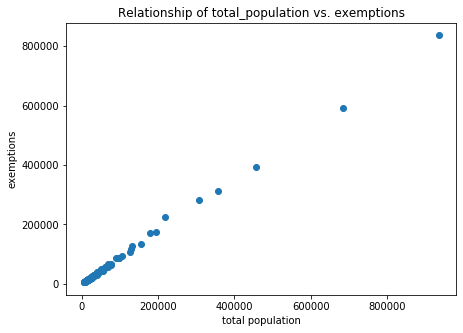

In [3]:
# other downloaded data
population = pd.read_csv('../Data/PEP_2016_PEPANNRES_with_ann.csv',header=[0,1])
population = population.iloc[1:,[2,-1]]
population.columns = ['county','total_population']
population_change = pd.read_csv('../Data/PEP_2016_PEPTCOMP_with_ann.csv',header=[0,1])
population_change = population_change.iloc[1:,[2,4,7]]
population_change.columns = ['county','natural_change','migration_change']
age_sex = pd.read_csv('../Data/PEP_2016_PEPAGESEX_with_ann.csv',skiprows = 0, header=1)
age_sex = age_sex[['Geography','Population Estimate (as of July 1) - 2016 - Male; Total',
                   'Population Estimate (as of July 1) - 2016 - Both Sexes; 65 years and over',
                  'Population Estimate (as of July 1) - 2016 - Male; 65 years and over']]
age_sex.columns = ['county','male_population','male_65_and_over','female_65_and_over']

# irs_health data from Seth's code
irs_health = pd.read_csv('../Data/irs_2016_health.csv',header=0,nrows=95)
irs_health['not_insured_per_capita'] = irs_health.health_care_payments/irs_health.exemptions
irs_health['medical_expense_deductions_per_capita'] = irs_health.Medical_Dental_expenses_deductions/irs_health.exemptions
irs_health = irs_health[['county','exemptions','not_insured_per_capita','medical_expense_deductions_per_capita']]

# Merge all other data
other_data = pd.merge(population,population_change,on='county',how='outer')
other_data = pd.merge(other_data, age_sex, on='county', how='left')
other_data.county = other_data.county.str[0:-11]
other_data = pd.merge(other_data, irs_health, on='county',how='left')

# Explore the relationship between population and exemptions
fig, ax = plt.subplots(figsize = (7,5))
ax.scatter(other_data.total_population, other_data.exemptions)
ax.set_xlabel('total population')
ax.set_ylabel('exemptions')
plt.title('Relationship of total_population vs. exemptions');

In [4]:
other_data = other_data.drop(columns=['exemptions'])
ha_all_data = pd.merge(tn_ha_cost2,other_data,on='county',how='inner')
ha_all_data = ha_all_data.dropna()
cancer_all_data = pd.merge(tn_cancer_cost2,other_data,on='county',how='inner')

In [5]:
ha_all_data.tail(3)

,county,avg_income,analysis_value,cost_income_ratio,classifer,urban_Urban,total_population,natural_change,migration_change,male_population,male_65_and_over,female_65_and_over,not_insured_per_capita,medical_expense_deductions_per_capita
92,White County,40297.0,40717.0,1.010423,1,0,26653,-378,1136,13087,5311,2381,0.016644,0.017544
93,Williamson County,129769.0,61541.0,0.474235,0,1,219107,6602,28729,107110,27316,12391,0.008841,0.030679
94,Wilson County,67411.0,52387.0,0.777128,0,1,132781,2729,15548,65080,20180,9234,0.013699,0.027319


### Modeling (Heart Attack Data) ###

In [6]:
ha_all_data.isnull().sum()

county                                   0
avg_income                               0
analysis_value                           0
cost_income_ratio                        0
classifer                                0
urban_Urban                              0
total_population                         0
natural_change                           0
migration_change                         0
male_population                          0
male_65_and_over                         0
female_65_and_over                       0
not_insured_per_capita                   0
medical_expense_deductions_per_capita    0
dtype: int64

In [7]:
X = ha_all_data.drop(columns = ['classifer','county','avg_income','analysis_value','cost_income_ratio'])
y = ha_all_data.classifer
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

forest = RandomForestClassifier(n_estimators = 1000, max_depth = 5, min_samples_leaf = 20)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [8]:
y_pred_train = forest.predict(X_train)
print(metrics.accuracy_score(y_train, y_pred_train))

0.7352941176470589


In [9]:
y_pred = forest.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.7391304347826086


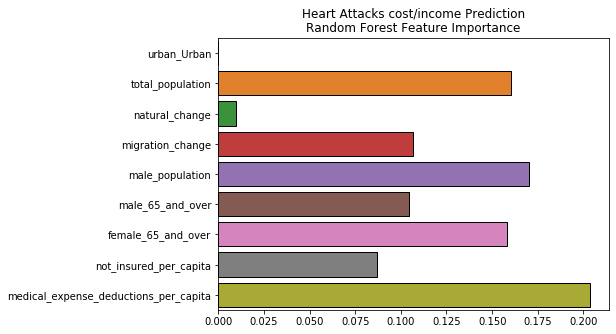

In [10]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(x = forest.feature_importances_, y = list(X.columns), ax = ax, edgecolor = 'black')
plt.title('Heart Attacks cost/income Prediction\nRandom Forest Feature Importance');

### Modeling (Cancer Data) ###

In [11]:
cancer_all_data.isnull().sum()

county                                   0
avg_income                               0
analysis_value                           0
cost_income_ratio                        0
classifer                                0
urban_Urban                              0
total_population                         0
natural_change                           0
migration_change                         0
male_population                          0
male_65_and_over                         0
female_65_and_over                       0
not_insured_per_capita                   0
medical_expense_deductions_per_capita    0
dtype: int64

In [12]:
# X = cancer_all_data.drop(columns = ['classifer','county','cost_income_ratio'])
X = cancer_all_data.drop(columns = ['classifer','county','avg_income','analysis_value','cost_income_ratio'])
y = cancer_all_data.classifer
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

forest = RandomForestClassifier(n_estimators = 1000, max_depth = 5, min_samples_leaf = 20)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [13]:
y_pred_train = forest.predict(X_train)
print(metrics.accuracy_score(y_train, y_pred_train))

0.7605633802816901


In [14]:
y_pred = forest.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.8333333333333334


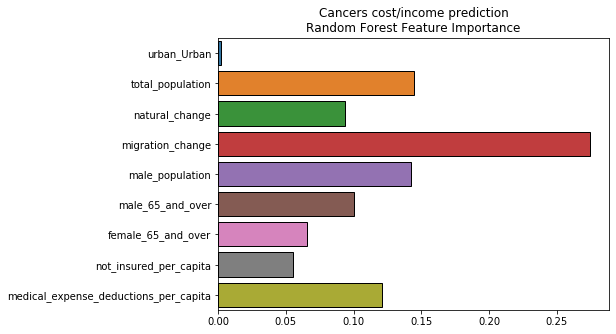

In [15]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(x = forest.feature_importances_, y = list(X.columns), ax = ax, edgecolor = 'black')
plt.title('Cancers cost/income prediction\nRandom Forest Feature Importance');